Code modified from:
https://github.com/RockyXu66/Kaggle_Flowers_Classification_Keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
!nvidia-smi

Thu Jun  9 06:54:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |   9066MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import time
import zipfile
import cv2
import keras
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils

from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

import tensorflow_hub as hub
import tensorflow_datasets as tfds
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display
print('finished')

finished


In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

Version:  2.8.2
Hub version:  0.12.0
GPU is available


In [4]:
zip_ref = zipfile.ZipFile('drive/My Drive/archive.zip', 'r')
zip_ref.extractall('unzipped_folder') # unzip directory
zip_ref.close()

In [5]:
# base_path = 'Dataset/flowers/'
base_path = 'unzipped_folder/flowers/'
# daisy, dandelion, rose, sunflower, tulip
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [6]:
base_path

'unzipped_folder/flowers/'

In [7]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [8]:
for i in range(5):
  print(len(fnames[i]))

764
1052
784
733
984


In [9]:
for i in range(3):
  print(fnames[i])
print(' len of fnames is ' + str(len(fnames)))

['unzipped_folder/flowers/daisy/2454280137_e1637536ae_n.jpg', 'unzipped_folder/flowers/daisy/5874818796_3efbb8769d.jpg', 'unzipped_folder/flowers/daisy/34337108550_0b619aa726_n.jpg', 'unzipped_folder/flowers/daisy/154332674_453cea64f4.jpg', 'unzipped_folder/flowers/daisy/8094774544_35465c1c64.jpg', 'unzipped_folder/flowers/daisy/7630511450_02d3292e90.jpg', 'unzipped_folder/flowers/daisy/34733243845_29f1c30634_n.jpg', 'unzipped_folder/flowers/daisy/33901756843_94e198d40e_n.jpg', 'unzipped_folder/flowers/daisy/3780380240_ef9ec1b737_m.jpg', 'unzipped_folder/flowers/daisy/34310869690_56cdc84a17_n.jpg', 'unzipped_folder/flowers/daisy/5665834973_76bd6c6523_m.jpg', 'unzipped_folder/flowers/daisy/10555826524_423eb8bf71_n.jpg', 'unzipped_folder/flowers/daisy/2520369272_1dcdb5a892_m.jpg', 'unzipped_folder/flowers/daisy/8348621545_8f02b82662_n.jpg', 'unzipped_folder/flowers/daisy/4851353993_2cbbbd1040_n.jpg', 'unzipped_folder/flowers/daisy/9496209717_25a6ebdab6_m.jpg', 'unzipped_folder/flowers/da

In [10]:
daisies = fnames[0]
daisy1 = daisies[0]

read = cv2.imread(daisy1)
print(read)

[[[20 29 19]
  [38 52 40]
  [29 51 33]
  ...
  [ 0 64 38]
  [ 4 59 40]
  [ 1 65 36]]

 [[15 26 16]
  [33 47 35]
  [29 50 35]
  ...
  [ 0 63 28]
  [ 0 72 26]
  [ 0 63 37]]

 [[16 32 21]
  [28 44 33]
  [27 48 33]
  ...
  [15 67 43]
  [ 0 66 32]
  [ 8 68 34]]

 ...

 [[ 8  8  8]
  [10 10 10]
  [10 10 10]
  ...
  [11 13 13]
  [ 7  7  7]
  [ 5  5  5]]

 [[ 7  5  5]
  [ 7  7  7]
  [ 7  7  7]
  ...
  [11 13 13]
  [ 2  4  4]
  [ 2  2  2]]

 [[ 5  3  3]
  [ 6  4  4]
  [ 5  5  5]
  ...
  [ 2  7  5]
  [ 0  1  0]
  [ 0  2  0]]]


In [11]:
images = []
for flower in fnames:
  one_category_images = []
  for image in flower:
    if cv2.imread(image) is not None:
      rgb_image = cv2.imread(image)
      one_category_images.append(rgb_image)
  images.append(one_category_images)

In [12]:
len(images)

5

In [13]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

134,134 is the min shape for daisy
98,134 is the min shape for dandelion
80,150 is the min shape for rose
134,152 is the min shape for sunflower
134,134 is the min shape for tulip


In [14]:
def convertToRGB(img):
  return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

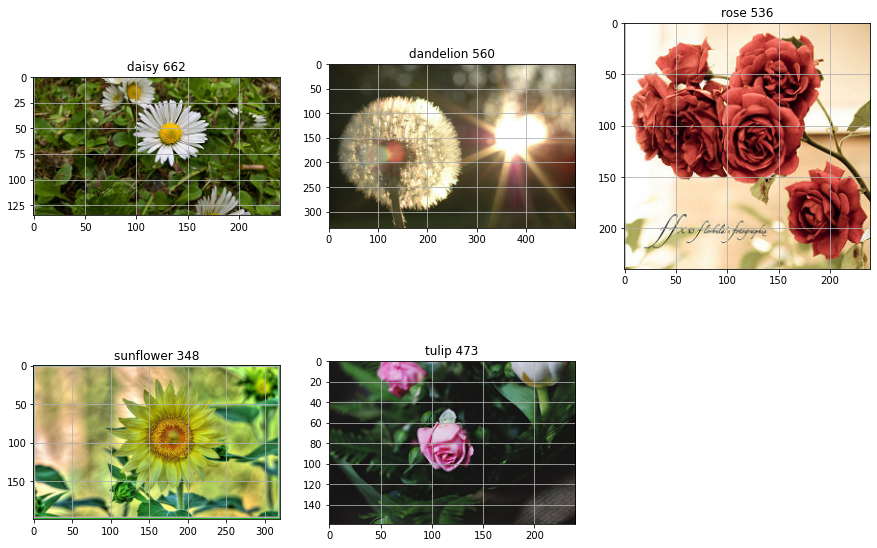

In [15]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(convertToRGB(imgs[idx]))
    plt.grid('off')
    plt.title(categories[i] + ' ' + str(idx))
plt.show()

In [16]:
# Apply resize to all images
img_width, img_height = 224, 224
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [17]:
len(resized_images)

5

In [18]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

In [19]:
len(train_images)

5

In [20]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[611, 841, 627, 586, 787]
sum of train images: 3452
[153, 211, 157, 147, 197]
sum of val_images: 865


In [21]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [22]:
len(train_images)

3452

In [23]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

print(train_categories[4])
train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)
print(train_categories[4])

Before converting
train data: (3452, 224, 224, 3)
train labels: (3452,)
0

After converting
train data: (3452, 224, 224, 3)
train labels: (3452, 5)
0


In [24]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [25]:
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (3400, 224, 224, 3)
shape of train labels: (3400, 5)
shape of val data: (860, 224, 224, 3)
shape of val labels: (860, 5)


In [26]:
train_data = tf.keras.applications.vgg16.preprocess_input(train_data)
val_data = tf.keras.applications.vgg16.preprocess_input(val_data)

In [27]:
vgg = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

In [28]:
vgg.trainable = False

In [29]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:
inputs = keras.Input(shape = (224, 224, 3))
x = vgg(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1000)(x)
x = keras.layers.Dense(100)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [31]:
batch_size = 32
epochs1 = 3

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [33]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1000)              513000    
                                                                 
 dense_1 (Dense)             (None, 100)               100100    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                             

In [35]:
train_labels

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [36]:
train_labels_index = []
for label in train_labels:
  for i in range(5):
    if label[i] == 1.0:
      train_labels_index.append(i)

In [37]:
array = np.array(train_labels_index)

In [38]:
print(array)

[2 1 3 ... 4 1 4]


In [39]:
start = time.time()

model_scratch_info = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs1, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/3
106/106 - 53s - loss: 1.1921e-07 - accuracy: 0.8000 - val_loss: 1.1921e-07 - val_accuracy: 0.8000 - 53s/epoch - 496ms/step
Epoch 2/3
106/106 - 43s - loss: 1.1921e-07 - accuracy: 0.8000 - val_loss: 1.1921e-07 - val_accuracy: 0.8000 - 43s/epoch - 409ms/step
Epoch 3/3
106/106 - 45s - loss: 1.1921e-07 - accuracy: 0.8000 - val_loss: 1.1921e-07 - val_accuracy: 0.8000 - 45s/epoch - 423ms/step


In [40]:
results = model.evaluate(val_generator)
print('loss: ', results[0])
print('accuracy: ', results[1])

27/27 [==============================] - 4s 152ms/step - loss: 1.1921e-07 - accuracy: 0.8000
loss:  1.1920930376163597e-07
accuracy:  0.7999999523162842


[0.8000003695487976, 0.8000003695487976, 0.8000003099441528]


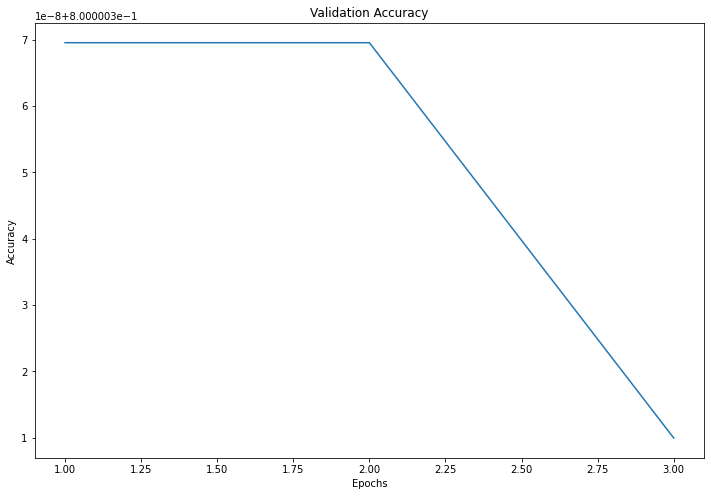

In [41]:
loss_val = model_scratch_info.history['accuracy']
print(loss_val)
epochs = [1, 2, 3]
plt.plot(epochs, loss_val)
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [42]:
predictions = model.predict(val_data)

In [43]:
argmax_pred = np.argmax(predictions, axis = -1)
argmax_pred.shape

(860,)

In [44]:
predictions_list = []
for prediction in predictions:
  for i in prediction:
    predictions_list.append(i)

In [45]:
predictions_array = np.array(predictions_list)

In [46]:
predictions_array.shape

(860,)

In [47]:
val_labels_index = []
for label in val_labels:
  for i in range(5):
    if label[i] == 1.0:
      val_labels_index.append(i)

In [48]:
array_ = np.array(val_labels_index)

In [49]:
array_.shape

(860,)

In [50]:
argmax_label = np.argmax(val_labels, axis = -1)

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(argmax_pred, argmax_label)

array([[152, 211, 156, 147, 194],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

Everything after this is old code -- disregard

In [56]:
epochs

[1, 2, 3]

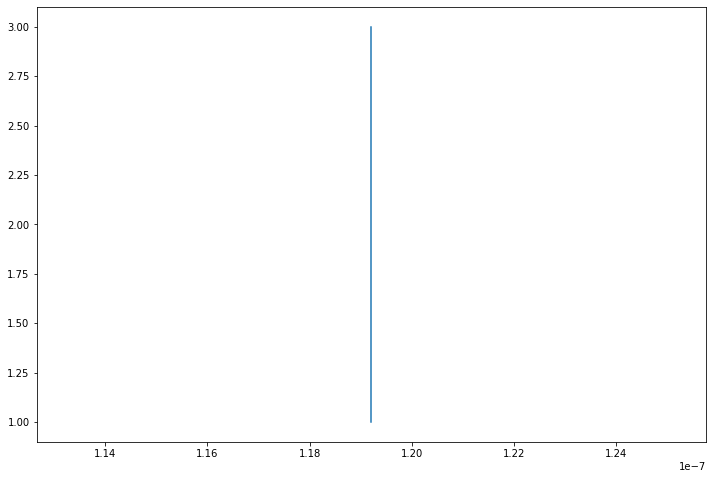

In [57]:
plt.plot(loss_val, epochs)


In [42]:
results = model.evaluate(val_generator)
print('loss: ', results[0])
print('accuracy: ', results[1])

27/27 [==============================] - 8s 257ms/step - loss: 1.1921e-07 - accuracy: 0.4023
loss:  1.1920930376163597e-07
accuracy:  0.4023256301879883


In [44]:
loss_train = history.history['train_loss']

KeyError: ignored

In [45]:
x = vgg.output
# x = Dense(1000, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)

In [ ]:
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.summary()

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
batch_size = 32
epochs1 = 10
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [ ]:
model.summary()

In [ ]:
start = time.time()

model_scratch_info = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs1, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)

In [ ]:
def create_model_from_scratch():

    """
     train from scratch
    """
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=train_data.shape[1:], activation='relu', name='conv_1'))
    model.add(Conv2D(32, (3,3), activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
    model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'))
    model.add(Conv2D(128, (3,3), activation='relu', name='conv_6'))
    model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', name='dense_2'))
    model.add(Dense(len(categories), name='output'))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [ ]:
model_scratch = create_model_from_scratch()
model_scratch.summary()

In [ ]:
batch_size = 32
epochs1 = 10
epochs2 = 10
epochs3 = 10

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [ ]:
start = time.time()

model_scratch_info = model_scratch.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/batch_size,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs1, 
    validation_steps=len(val_data)/batch_size, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=2
)